# MNIST Example in PyTorch

In [3]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn.functional as F  # Added import

# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Define device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cuda


In [4]:
# Define transformations for training and testing datasets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),       # Data augmentation: horizontal flip
    transforms.RandomCrop(32, padding=4),    # Data augmentation: random crop with padding
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # Normalize with CIFAR-10 mean and std
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 training and testing datasets
train_dataset = torchvision.datasets.CIFAR10(root='/home/shiyao/CNN_MNIST/data/CIFAR10', train=True,
                                             download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(root='/home/shiyao/CNN_MNIST/data/CIFAR10', train=False,
                                            download=True, transform=transform_test)

# Split training data into training and validation subsets
train_size = int(0.9 * len(train_dataset))  # 45,000 samples for training
val_size = len(train_dataset) - train_size  # 5,000 samples for validation
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Define DataLoaders for training, validation, and testing
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


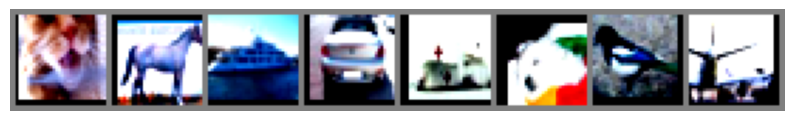

GroundTruth: cat horse ship car ship dog bird plane


In [5]:
# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.figure(figsize=(10,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Corrected line

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
print('GroundTruth:', ' '.join(f'{classes[labels[j]]}' for j in range(8)))


In [ ]:
# Define the Simple CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # Input: 3 channels, Output: 32
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Input: 32, Output: 64
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Input: 64, Output: 128
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)# Input: 128, Output: 128
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)  # Reduce spatial size by 2
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        # Convolutional layers with ReLU and BatchNorm
        x = self.pool(F.relu(self.bn1(self.conv1(x))))   # [batch, 32, 16, 16]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))   # [batch, 64, 8, 8]
        
        x = F.relu(self.bn3(self.conv3(x)))              # [batch, 128, 8, 8]
        x = F.relu(self.bn4(self.conv4(x)))              # [batch, 128, 8, 8]
        x = self.dropout1(x)
        
        # Flatten the tensor
        x = x.view(-1, 128 * 8 * 8)
        
        # Fully connected layers with ReLU and Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)  # Output layer (logits)
        return x

# Instantiate the model, define loss function and optimizer
model = SimpleCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
# Function to train the model
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Function to evaluate the model

def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [16]:
# Define number of epochs
num_epochs = 25
best_val_acc = 0.0

# Create directory to save the best model
os.makedirs('models', exist_ok=True)

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    print(f'Epoch {epoch}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%\n')
    
    # Save the model if validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'models/best_cifar10_cnn.pth')
        print(f'Best model saved with accuracy: {best_val_acc:.2f}%\n')


Epoch 1/25
Train Loss: 1.5959 | Train Acc: 41.28%
Val Loss: 1.3243 | Val Acc: 54.20%

Best model saved with accuracy: 54.20%

Epoch 2/25
Train Loss: 1.2728 | Train Acc: 54.38%
Val Loss: 1.2842 | Val Acc: 53.42%

Epoch 3/25
Train Loss: 1.1330 | Train Acc: 60.08%
Val Loss: 1.0982 | Val Acc: 61.48%

Best model saved with accuracy: 61.48%

Epoch 4/25
Train Loss: 1.0391 | Train Acc: 63.60%
Val Loss: 1.0027 | Val Acc: 64.98%

Best model saved with accuracy: 64.98%

Epoch 5/25
Train Loss: 0.9703 | Train Acc: 66.18%
Val Loss: 0.8804 | Val Acc: 68.54%

Best model saved with accuracy: 68.54%

Epoch 6/25
Train Loss: 0.9190 | Train Acc: 68.24%
Val Loss: 0.7810 | Val Acc: 72.04%

Best model saved with accuracy: 72.04%

Epoch 7/25
Train Loss: 0.8708 | Train Acc: 70.08%
Val Loss: 0.9041 | Val Acc: 68.06%

Epoch 8/25
Train Loss: 0.8273 | Train Acc: 71.84%
Val Loss: 0.7345 | Val Acc: 74.20%

Best model saved with accuracy: 74.20%

Epoch 9/25
Train Loss: 0.7952 | Train Acc: 72.78%
Val Loss: 0.7790 | Val

In [8]:
# Load the best model
model.load_state_dict(torch.load('models/best_cifar10_cnn.pth'))
model.to(device)

# Evaluate on the test set
test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')


Test Loss: 0.4929 | Test Acc: 83.61%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


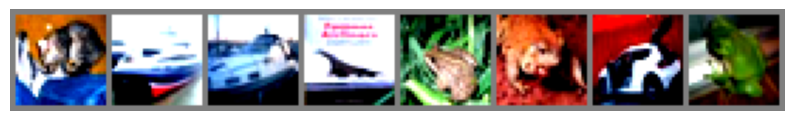

GroundTruth: cat ship ship plane frog frog car frog
Predicted: cat ship ship plane frog frog car frog


In [9]:
# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.figure(figsize=(10,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Use next() instead of .next()

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
print('GroundTruth:', ' '.join(f'{classes[labels[j]]}' for j in range(8)))

# Predict
images = images[:8].to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print('Predicted:', ' '.join(f'{classes[predicted[j]]}' for j in range(8)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


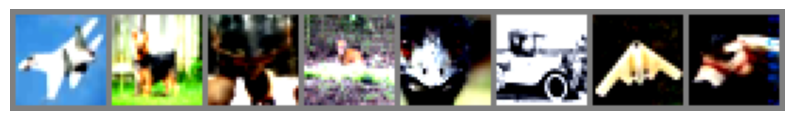

GroundTruth: plane dog deer deer bird car plane horse
Predicted: deer deer cat bird cat truck bird dog


In [10]:
# Function to collect misclassified images (as defined earlier)
def get_misclassified(model, loader, device, classes, max_images=8):
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Find where predictions do not match labels
            mis_mask = preds != labels
            mis_images_batch = inputs[mis_mask]
            mis_labels_batch = labels[mis_mask]
            mis_preds_batch = preds[mis_mask]
            
            # Append to the lists
            misclassified_images.append(mis_images_batch.cpu())
            misclassified_labels.append(mis_labels_batch.cpu())
            misclassified_preds.append(mis_preds_batch.cpu())
            
            # Check if we have collected enough images
            total_mis = sum([len(m) for m in misclassified_images])
            if total_mis >= max_images:
                break
    
    # Concatenate all collected batches and select the first 'max_images' samples
    mis_images = torch.cat(misclassified_images)[:max_images]
    mis_labels = torch.cat(misclassified_labels)[:max_images]
    mis_preds = torch.cat(misclassified_preds)[:max_images]
    
    return mis_images, mis_labels, mis_preds

# Collect misclassified images
mis_images, mis_labels, mis_preds = get_misclassified(model, test_loader, device, classes, max_images=8)

# Show misclassified images
imshow(torchvision.utils.make_grid(mis_images))

# Print Ground Truth and Predicted Labels
print('GroundTruth:', ' '.join(f'{classes[mis_labels[j]]}' for j in range(len(mis_labels))))
print('Predicted:', ' '.join(f'{classes[mis_preds[j]]}' for j in range(len(mis_preds))))
